# 📄 Raport Techniczny: Etap 3 - Wizualizacja danych. Klasyfikacja i ewaluacja modeli 

**Autor:** Małgorzata Stawińska

**Cel:** Wizualizacja danych oraz zbudowanie modeli klasyfikacyjnych rozpoznających typy krwinek na podstawie wcześniej wyekstrahowanych cech oraz ocena skuteczności tych modeli.


**Zakres prac:**
1.  **Przygotowanie danych:** wczytanie zbioru cech, analiza statystyczna oraz wizualizacja rozkładów danych.
2.  **Wizualizacja danych:** przedstawienie rozkładu klas, histogramów cech, wykresów pudełkowych (boxplot), korelacji między cechami oraz redukcji wymiarowości (PCA, t-SNE).
3.  **Implementacja klasyfikatorów:** trenowanie i testowanie wybranych algorytmów uczenia maszynowego (SVM, k-NN, Random Forest).
4.  **Ewaluacja modeli:** porównanie skuteczności klasyfikatorów przy użyciu miar takich jak accuracy, macierz pomyłek oraz raport klasyfikacji.
5.  **Analiza wyników i wnioski:** interpretacja otrzymanych rezultatów oraz wskazanie najlepszego modelu do rozpoznawania typów krwinek.

## Wizualizacja danych

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


In [3]:
# Wczytanie danych
CSV_PATH = "blood_cells_features.csv"

if not os.path.exists(CSV_PATH):
    # awaryjnie:
    for root, _, files in os.walk("."):
        if "blood_cells_features.csv" in files:
            CSV_PATH = os.path.join(root, "blood_cells_features.csv")
            break

print("Używam pliku:", CSV_PATH)

df = pd.read_csv(CSV_PATH)
df.head()


Używam pliku: blood_cells_features.csv


,filename,label,mean_b,mean_g,mean_r,area,perimeter,circularity,hu1,hu2,hu3,hu4,hu5,hu6,hu7,texture_contrast,texture_homogeneity,texture_energy,texture_correlation
0,crop_1044.jpg,Platelets,190.225198,177.041942,172.480723,4957.5,824.957492,0.091540,0.731401,2.834303,3.433039,4.249345,-8.440416,5.683641,8.138895,3136.992003,0.816544,0.576558,0.788581
1,crop_1061.jpg,Platelets,195.093610,148.358786,166.293930,2946.5,585.394004,0.108049,0.765389,2.487500,4.203611,5.788321,11.265521,-8.467161,-10.809354,1051.160187,0.904409,0.790166,0.866924
2,crop_107.jpg,Platelets,207.247992,113.513462,138.073217,4005.0,628.749341,0.127308,0.785558,3.053793,4.555360,6.265395,-11.900177,-8.042452,-11.771257,1062.544168,0.850596,0.719475,0.844073
3,crop_1103.jpg,Platelets,197.505340,166.032265,167.923881,4150.5,646.991983,0.124598,0.767046,2.539626,3.834098,5.654075,-10.484479,-7.025596,-10.640217,1376.295768,0.863000,0.708777,0.880121
4,crop_1104.jpg,Platelets,178.853955,111.877427,146.285714,3199.0,599.979790,0.111674,0.732203,2.101318,3.737659,5.170724,-9.923825,-6.381069,9.688097,756.768332,0.904105,0.769205,0.866913


In [4]:
# Podstawowe info o danych
print("Wymiary:", df.shape)
display(df.sample(5, random_state=42))

print("\nTypy kolumn:")
display(df.dtypes)

print("\nBraki danych (liczba):")
display(df.isna().sum().sort_values(ascending=False).head(20))

Wymiary: (3448, 19)


,filename,label,mean_b,mean_g,mean_r,area,perimeter,circularity,hu1,hu2,hu3,hu4,hu5,hu6,hu7,texture_contrast,texture_homogeneity,texture_energy,texture_correlation
2900,crop_701.jpg,RBC,163.193004,153.494889,172.817824,13129.0,1142.454966,0.126405,0.743902,3.019229,3.768039,4.554023,-8.751658,6.211800,9.119712,2150.945682,0.664097,0.188322,0.735609
51,crop_1703.jpg,Platelets,194.121795,157.639053,159.236193,3128.0,632.063050,0.098391,0.784065,4.744442,3.445277,6.146146,-11.130648,-8.533937,-11.059844,1441.874508,0.868395,0.728061,0.854080
567,crop_1328.jpg,RBC,167.116801,155.122031,175.459250,8979.5,994.663117,0.114054,0.793735,4.065574,4.302204,6.406812,11.770002,8.464690,12.464698,2944.993172,0.714936,0.396231,0.775036
3268,crop_1939.jpg,WBC,187.626198,100.449840,117.039617,7713.5,902.981877,0.118878,0.779905,2.738774,5.277371,6.926137,13.032079,8.345959,13.887327,1649.174213,0.639881,0.485193,0.766387
1987,crop_2828.jpg,RBC,162.474138,159.811129,175.715965,9324.5,894.153450,0.146559,0.791637,3.357472,4.921083,7.303245,14.010918,-9.243542,13.429867,2339.646407,0.735696,0.419200,0.826795



Typy kolumn:


filename                object
label                   object
mean_b                 float64
mean_g                 float64
mean_r                 float64
area                   float64
perimeter              float64
circularity            float64
hu1                    float64
hu2                    float64
hu3                    float64
hu4                    float64
hu5                    float64
hu6                    float64
hu7                    float64
texture_contrast       float64
texture_homogeneity    float64
texture_energy         float64
texture_correlation    float64
dtype: object


Braki danych (liczba):


filename               0
label                  0
mean_b                 0
mean_g                 0
mean_r                 0
area                   0
perimeter              0
circularity            0
hu1                    0
hu2                    0
hu3                    0
hu4                    0
hu5                    0
hu6                    0
hu7                    0
texture_contrast       0
texture_homogeneity    0
texture_energy         0
texture_correlation    0
dtype: int64

label
RBC          2936
WBC           263
Platelets     249
Name: count, dtype: int64

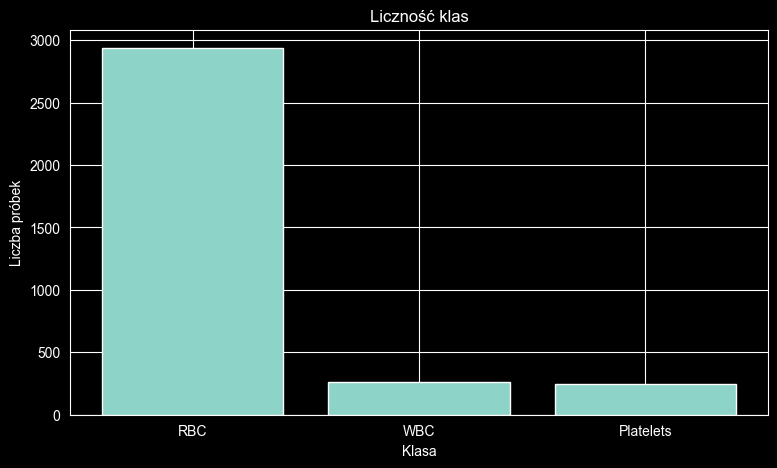

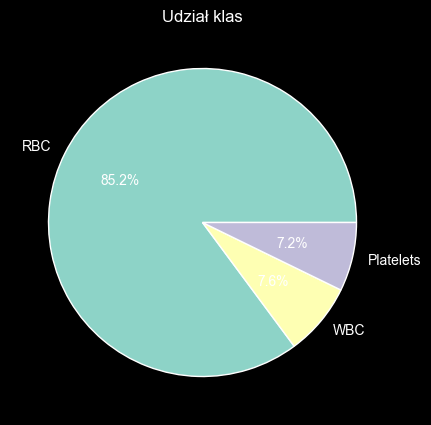

In [5]:
# Rozkład klas
class_counts = df["label"].value_counts()
display(class_counts)

plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.title("Liczność klas")
plt.xlabel("Klasa")
plt.ylabel("Liczba próbek")
plt.show()

plt.figure()
plt.pie(class_counts.values, labels=class_counts.index, autopct="%1.1f%%")
plt.title("Udział klas")
plt.show()

Analiza rozkładu klas wykazała istotną nierównowagę w zbiorze danych. Najliczniejszą klasą są krwinki czerwone, natomiast liczba próbek dla klas WBC oraz Platelets jest znacznie mniejsza.

Nierówny balans klas może prowadzić do zawyżenia miary accuracy, ponieważ modele uczą się najlepiej rozpoznawać klasę dominującą, kosztem słabszej skuteczności dla klas mniejszościowych.

In [6]:
# Statystyki opisowe cech
feature_cols = [c for c in df.columns if c not in ["filename", "label"]]
desc = df[feature_cols].describe().T
desc["missing"] = df[feature_cols].isna().sum()
display(desc.sort_values("std", ascending=False).head(20))

,count,mean,std,min,25%,50%,75%,max,missing
area,3448.0,10006.194751,2582.923133,607.000000,8972.250000,10656.250000,11757.875000,15664.000000,0
texture_contrast,3448.0,2370.482957,792.488978,208.821604,1750.634197,2350.149606,2946.467427,4903.949496,0
perimeter,3448.0,930.869469,179.180745,183.338094,821.113303,922.132635,1017.473997,1852.868301,0
mean_g,3448.0,157.454694,16.877119,69.300668,152.375420,160.225348,167.258644,198.493788,0
mean_b,3448.0,172.628083,16.441679,129.756750,162.262250,170.332129,179.169386,225.818386,0
mean_r,3448.0,178.196813,14.517517,94.363379,174.495224,180.614638,186.558155,210.035845,0
hu7,3448.0,0.172420,10.507640,-19.409911,-10.163915,6.064568,10.218014,19.108796,0
hu5,3448.0,2.058896,10.226569,-17.819430,-9.660699,8.612080,10.356576,19.905931,0
hu6,3448.0,1.246218,7.210886,-12.637708,-6.880824,6.012813,7.261116,13.735837,0
hu4,3448.0,5.372173,1.115310,2.033447,4.715564,5.303765,5.951284,10.762928,0


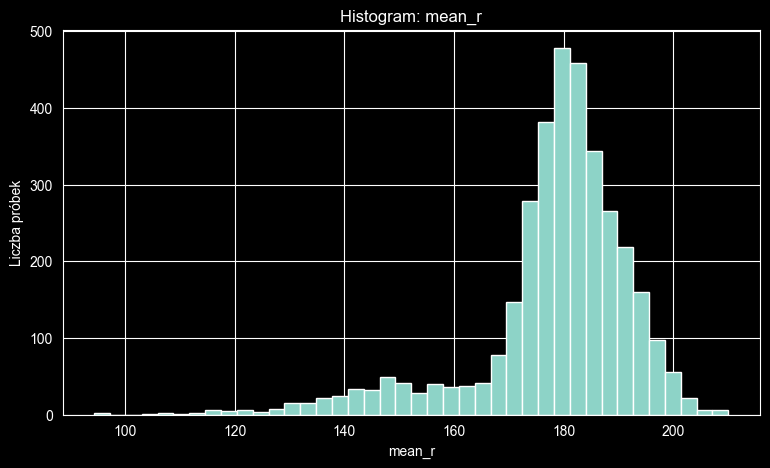

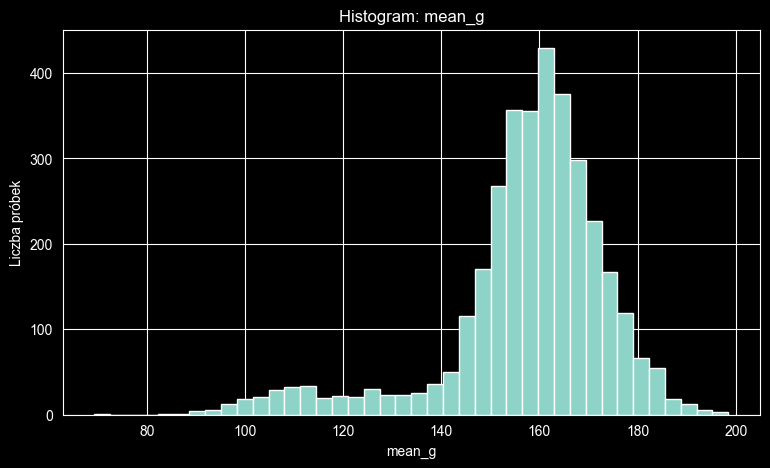

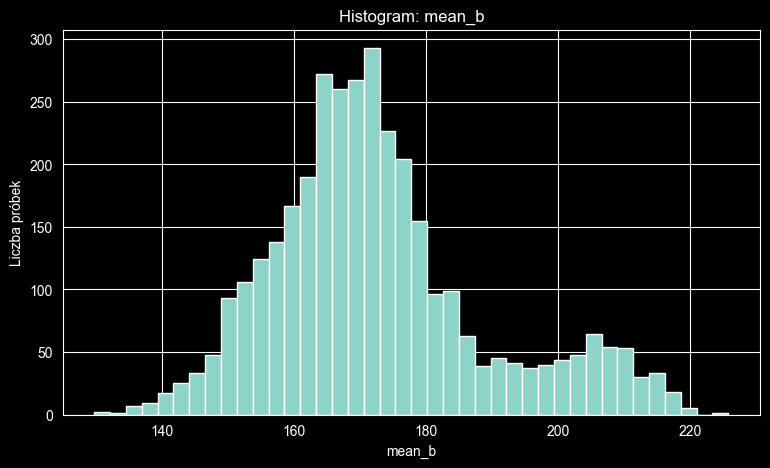

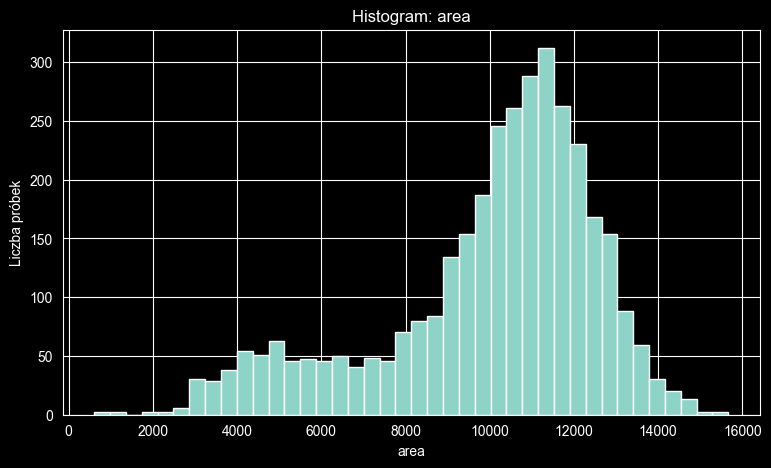

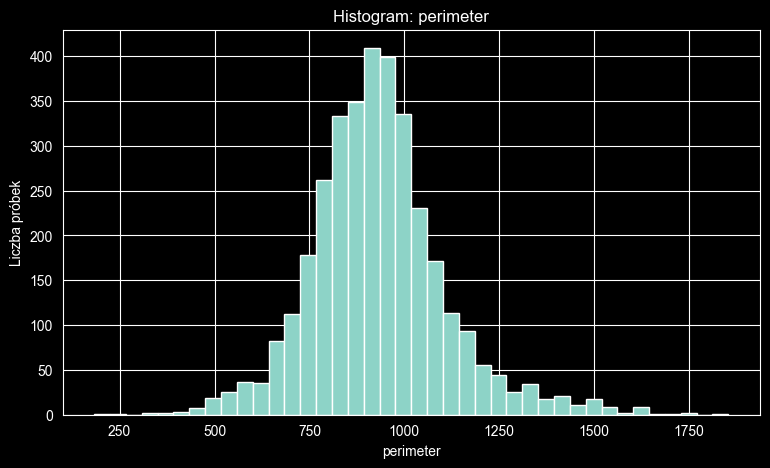

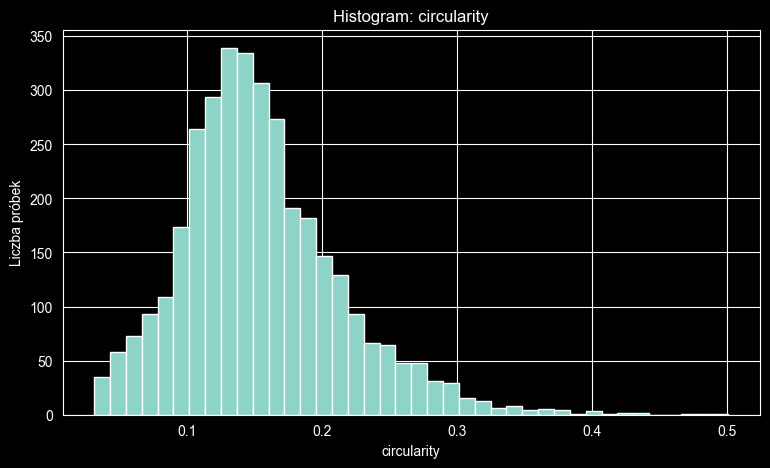

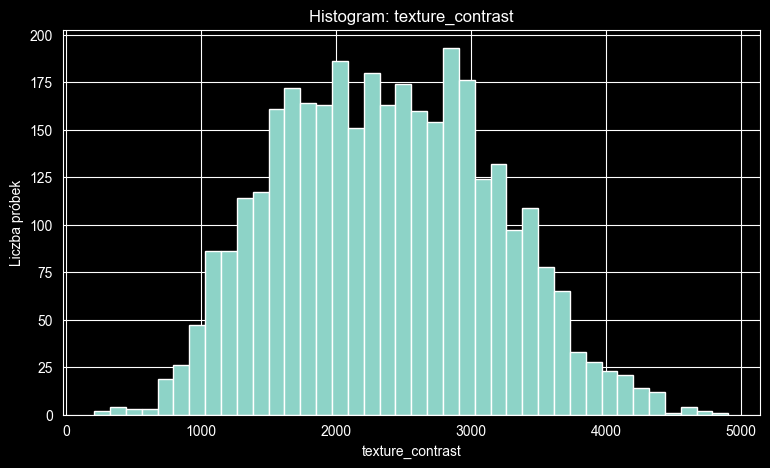

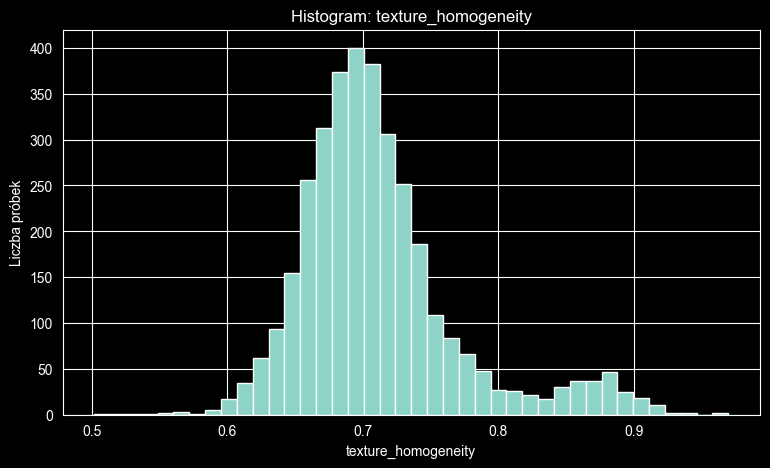

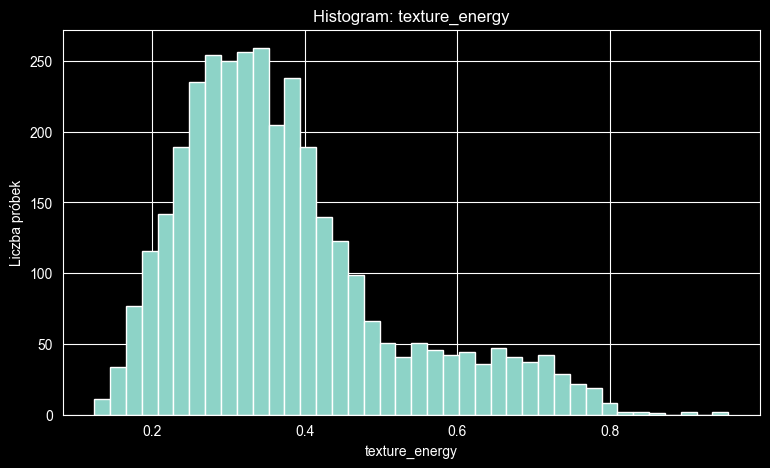

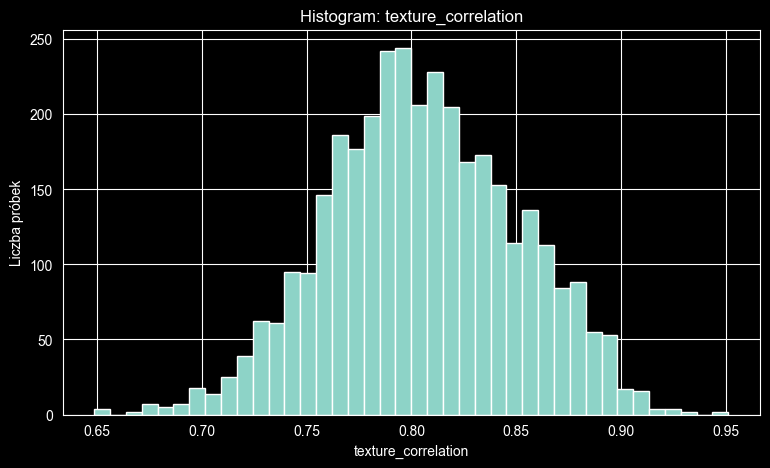

In [7]:
# Histogramy kilku wybranych cech (globalnie)
selected = [
    "mean_r", "mean_g", "mean_b",
    "area", "perimeter", "circularity",
    "texture_contrast", "texture_homogeneity", "texture_energy", "texture_correlation"
]
selected = [c for c in selected if c in df.columns]

for c in selected:
    plt.figure()
    plt.hist(df[c].dropna(), bins=40)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Liczba próbek")
    plt.show()


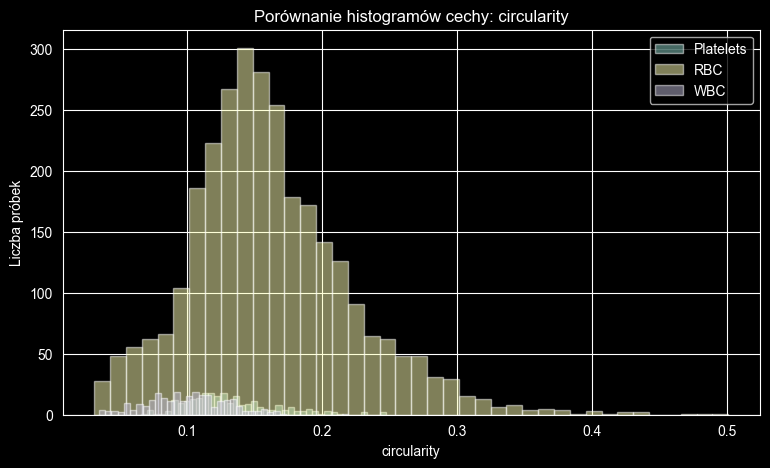

In [8]:
# Histogramy porównawcze: ta sama cecha, osobno dla każdej klasy

feature = "circularity" 
if feature in df.columns:
    labels = df["label"].unique()
    plt.figure()
    for lab in sorted(labels):
        data = df.loc[df["label"] == lab, feature].dropna().values
        plt.hist(data, bins=40, alpha=0.5, label=str(lab))
    plt.title(f"Porównanie histogramów cechy: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Liczba próbek")
    plt.legend()
    plt.show()
else:
    print("Nie ma takiej cechy:", feature)


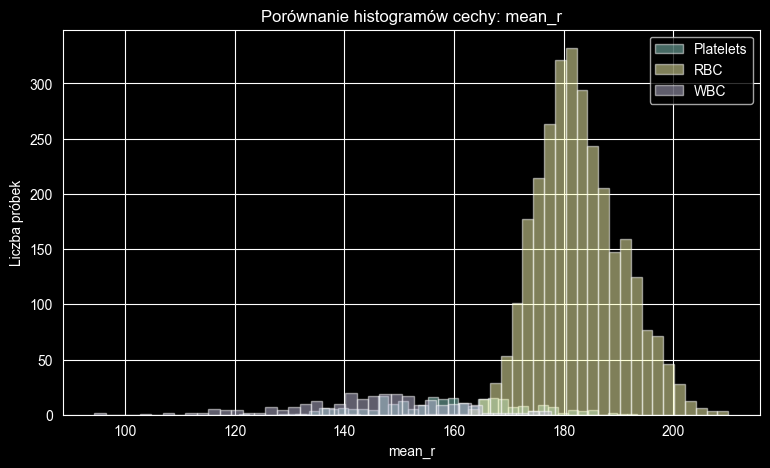

In [9]:
# Histogramy porównawcze: ta sama cecha, osobno dla każdej klasy

feature = "mean_r" 
if feature in df.columns:
    labels = df["label"].unique()
    plt.figure()
    for lab in sorted(labels):
        data = df.loc[df["label"] == lab, feature].dropna().values
        plt.hist(data, bins=40, alpha=0.5, label=str(lab))
    plt.title(f"Porównanie histogramów cechy: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Liczba próbek")
    plt.legend()
    plt.show()
else:
    print("Nie ma takiej cechy:", feature)


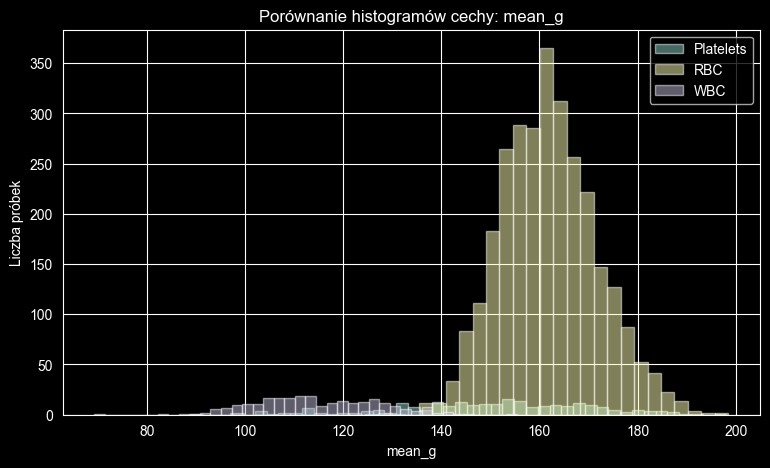

In [10]:
# Histogramy porównawcze: ta sama cecha, osobno dla każdej klasy

feature = "mean_g" 
if feature in df.columns:
    labels = df["label"].unique()
    plt.figure()
    for lab in sorted(labels):
        data = df.loc[df["label"] == lab, feature].dropna().values
        plt.hist(data, bins=40, alpha=0.5, label=str(lab))
    plt.title(f"Porównanie histogramów cechy: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Liczba próbek")
    plt.legend()
    plt.show()
else:
    print("Nie ma takiej cechy:", feature)


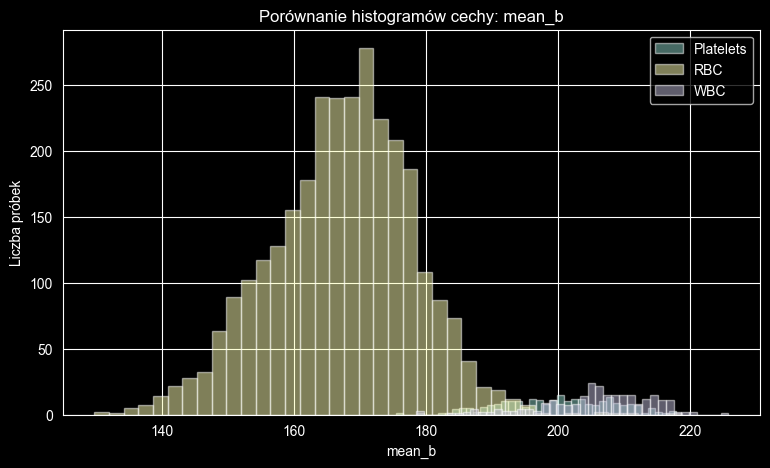

In [11]:
# Histogramy porównawcze: ta sama cecha, osobno dla każdej klasy

feature = "mean_b" 
if feature in df.columns:
    labels = df["label"].unique()
    plt.figure()
    for lab in sorted(labels):
        data = df.loc[df["label"] == lab, feature].dropna().values
        plt.hist(data, bins=40, alpha=0.5, label=str(lab))
    plt.title(f"Porównanie histogramów cechy: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Liczba próbek")
    plt.legend()
    plt.show()
else:
    print("Nie ma takiej cechy:", feature)


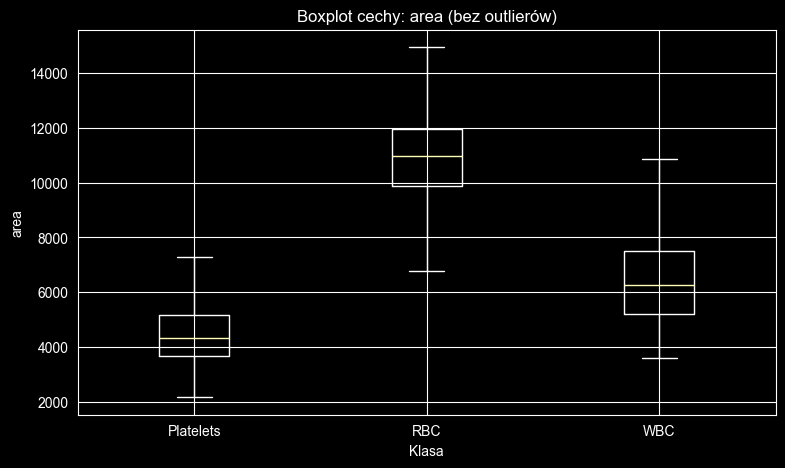

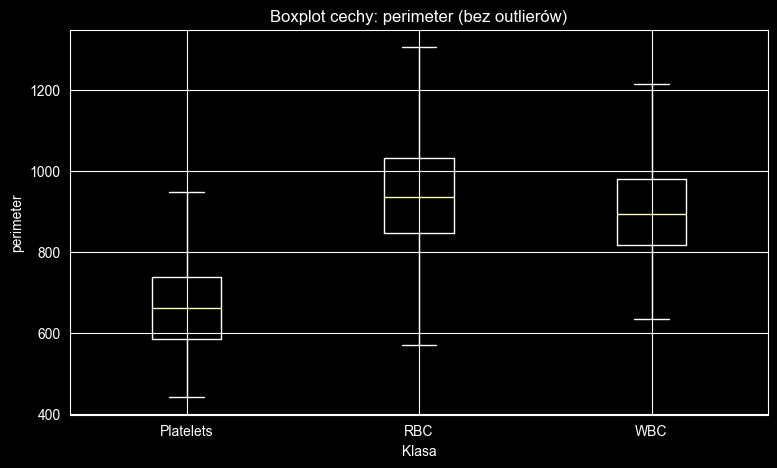

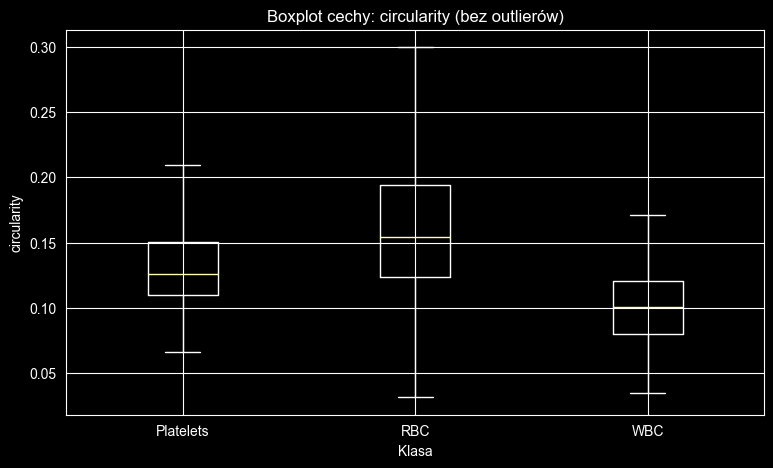

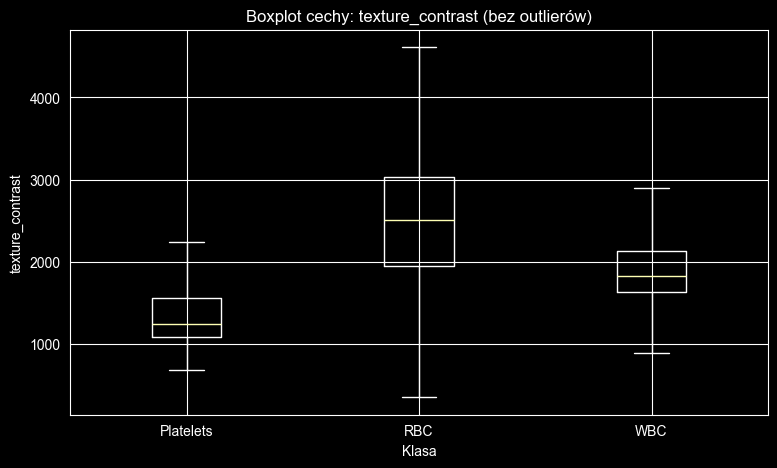

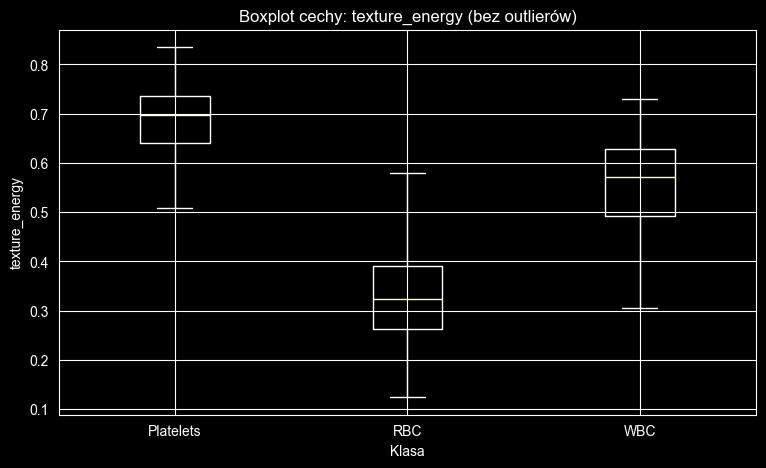

In [12]:
# Boxploty (wykresy pudełkowe) dla kilku cech – porównanie klas
box_feats = ["area", "perimeter", "circularity", "texture_contrast", "texture_energy"]
box_feats = [c for c in box_feats if c in df.columns]

labels_sorted = sorted(df["label"].unique())

for c in box_feats:
    data = [df.loc[df["label"] == lab, c].dropna().values for lab in labels_sorted]
    plt.figure(figsize=(9, 5))
    plt.boxplot(data, tick_labels=labels_sorted, showfliers=False)
    plt.title(f"Boxplot cechy: {c} (bez outlierów)")
    plt.xlabel("Klasa")
    plt.ylabel(c)
    plt.show()

Wykresy histogramów oraz wykresy pudełkowe wskazują, że cechy geometryczne, takie jak pole powierzchni (area), obwód (perimeter) oraz współczynnik kolistości (circularity), różnią się istotnie pomiędzy klasami.

Krwinki czerwone charakteryzują się największym polem i obwodem, natomiast płytki krwi (Platelets) osiągają najniższe wartości tych cech. Wartości circularity pozwalają w szczególności odróżnić Platelets od pozostałych klas.


Cechy kształtu stanowią jedne z najważniejszych atrybutów różnicujących klasy krwinek i będą mieć w takim razie kluczowe znaczenie w procesie klasyfikacji.

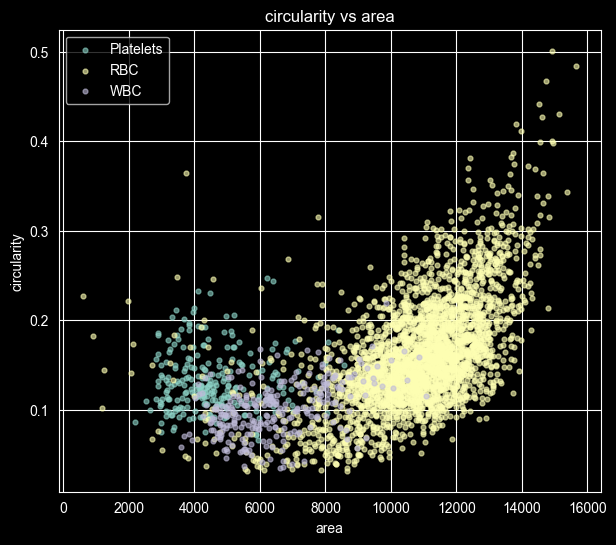

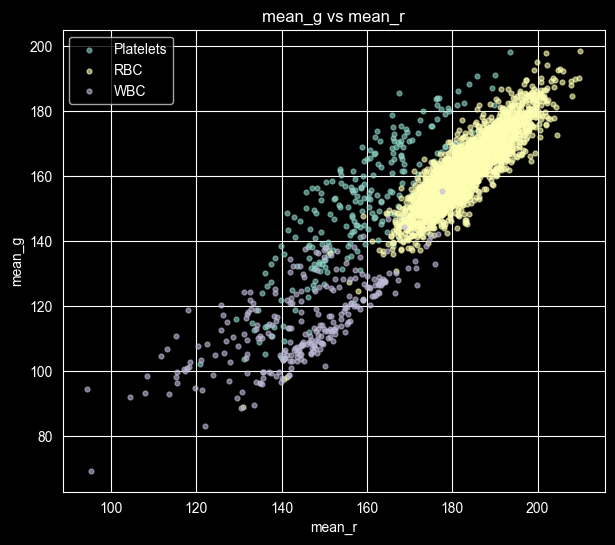

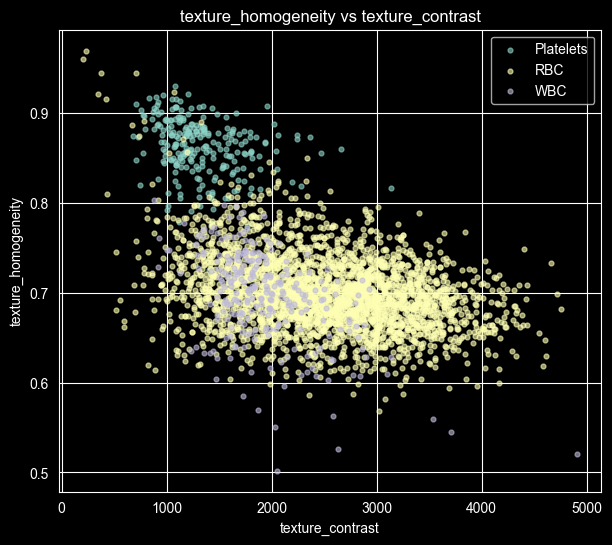

In [13]:
# Proste scatter ploty: dwie cechy na raz, kolor = klasa

def scatter_by_label(xcol, ycol):
    if xcol not in df.columns or ycol not in df.columns:
        print("Brak kolumn:", xcol, ycol)
        return
    plt.figure(figsize=(7, 6))
    for lab in sorted(df["label"].unique()):
        tmp = df[df["label"] == lab]
        plt.scatter(tmp[xcol], tmp[ycol], s=12, alpha=0.6, label=str(lab))
    plt.title(f"{ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.show()

scatter_by_label("area", "circularity")
scatter_by_label("mean_r", "mean_g")
scatter_by_label("texture_contrast", "texture_homogeneity")


Analiza wykresów cech tekstury pokazuje, że klasa Platelets wyraźnie różni się od pozostałych klas, tworząc odrębny klaster o wysokiej jednorodności.
Jednocześnie krwinki czerwone (RBC) i białe (WBC) wykazują silne nakładanie się rozkładów, co wskazuje, że same cechy tekstury nie są wystarczające do ich jednoznacznego rozróżnienia.

Cechy tekstury skutecznie odróżniają płytki krwi (Platelets), natomiast w przypadku klas RBC i WBC wymagane jest wykorzystanie dodatkowych cech, w szczególności cech kształtu.

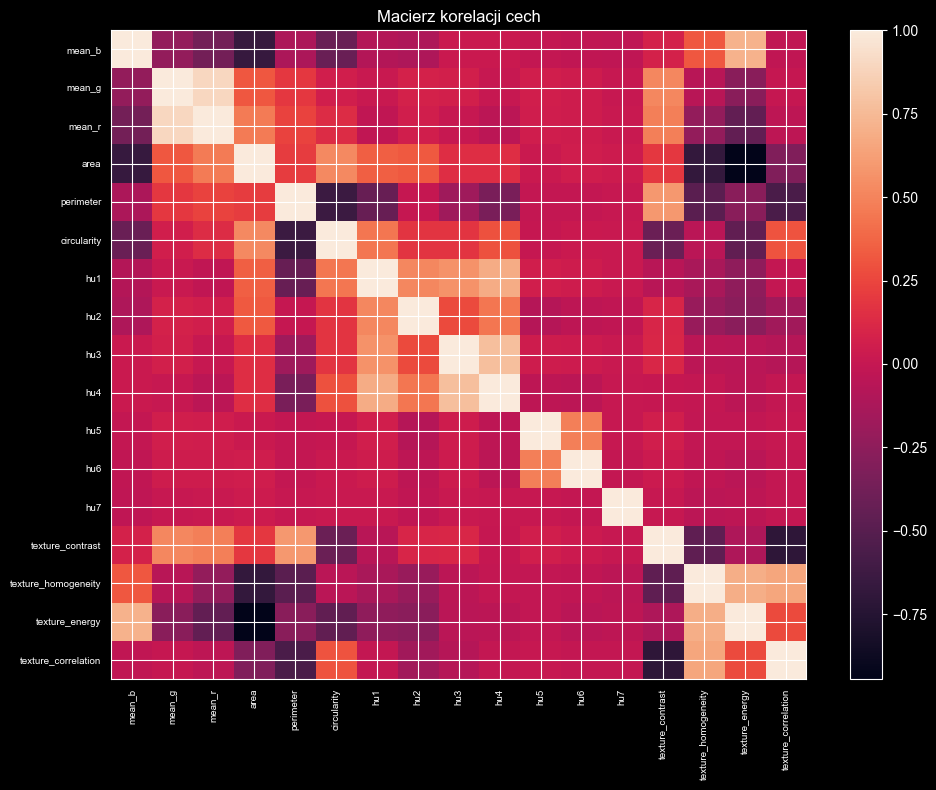

texture_energy       area                   0.943483
area                 texture_energy         0.943483
mean_g               mean_r                 0.899043
mean_r               mean_g                 0.899043
hu3                  hu4                    0.775587
hu4                  hu3                    0.775587
texture_energy       mean_b                 0.714226
mean_b               texture_energy         0.714226
texture_correlation  texture_contrast       0.707217
texture_contrast     texture_correlation    0.707217
texture_energy       texture_homogeneity    0.694627
texture_homogeneity  texture_energy         0.694627
hu1                  hu4                    0.684822
hu4                  hu1                    0.684822
texture_homogeneity  area                   0.670380
dtype: float64

In [14]:
# Korelacje cech (macierz korelacji) – heatmap z matplotlib
corr = df[feature_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.title("Macierz korelacji cech")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.index)), corr.index, fontsize=7)
plt.tight_layout()
plt.show()

# top 15 par o największej korelacji bezwzględnej (poza przekątną)
corr_abs = corr.abs()
np.fill_diagonal(corr_abs.values, 0)
pairs = (
    corr_abs.stack()
    .sort_values(ascending=False)
    .head(15)
)
display(pairs)


Macierz korelacji ujawnia silną zależność pomiędzy cechami mean r i g oraz umiarkowane korelacje pomiędzy momentami Hu. Cechy tekstury wykazują słabszą korelację z cechami geometrycznymi.

Pomimo częściowej redundancji niektórych cech, zestaw danych zawiera również cechy niosące komplementarną informację, co pozytywnie wpływa na zdolność modeli do rozróżniania klas.

Wyjaśniona wariancja (2 składowe): [0.25209752 0.19441815] suma = 0.4465156656171809


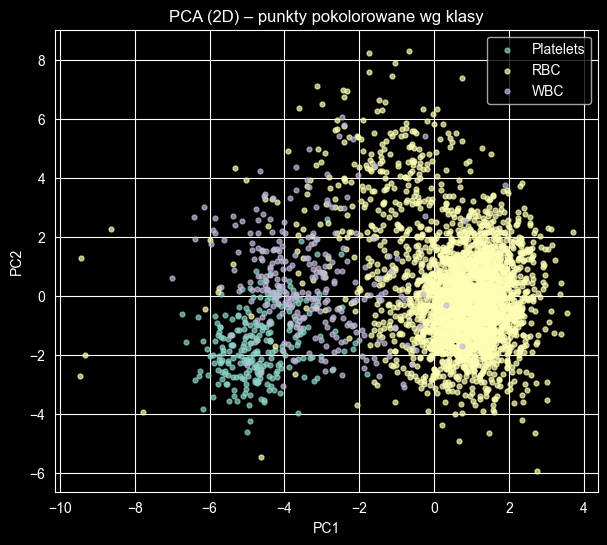

In [15]:
# PCA 2D – redukcja wymiaru do wizualizacji
# Najpierw: przygotowanie macierzy X, y
X = df[feature_cols].copy()
y = df["label"].copy()

# Standaryzacja + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Wyjaśniona wariancja (2 składowe):", pca.explained_variance_ratio_, 
      "suma =", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(7, 6))
for lab in sorted(y.unique()):
    idx = (y == lab).values
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=12, alpha=0.7, label=str(lab))
plt.title("PCA (2D) – punkty pokolorowane wg klasy")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


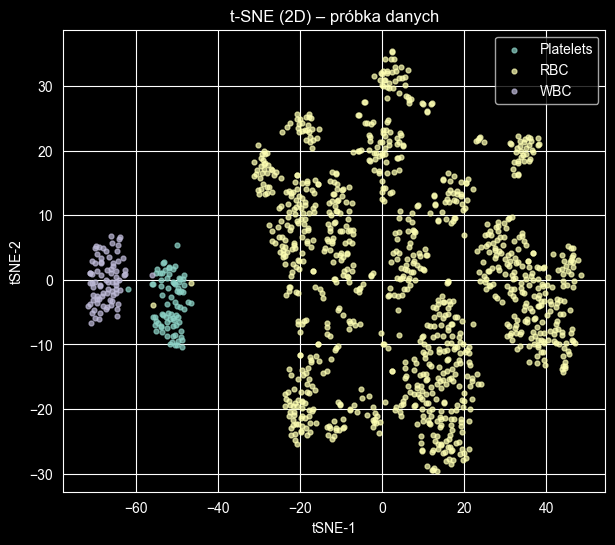

In [16]:
# t-SNE 2D – wolniejsze, ale lepiej rozdziela klastry

sample_n = 1200
rng = np.random.default_rng(42)
idx = rng.choice(len(X_scaled), size=min(sample_n, len(X_scaled)), replace=False)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled[idx])
y_tsne = y.iloc[idx].values

plt.figure(figsize=(7, 6))
for lab in sorted(np.unique(y_tsne)):
    m = (y_tsne == lab)
    plt.scatter(X_tsne[m, 0], X_tsne[m, 1], s=12, alpha=0.7, label=str(lab))
plt.title("t-SNE (2D) – próbka danych")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()

Wizualizacje PCA oraz t-SNE wskazują na częściową separację klas w przestrzeni dwuwymiarowej. Najlepiej odseparowaną klasą są Platelets, natomiast próbki RBC i WBC wykazują mocne nakładanie się.

Brak pełnej separacji liniowej uzasadnia zastosowanie modeli nieliniowych, takich jak SVM z jądrem RBF lub Random Forest.

## Modele klasyfikacyjne

 Klasyfikacja: SVM, k-NN, Random Forest

Poniżej:
- dzielimy dane na train/test (stratyfikacja),
- trenujemy 3 modele,
- porównujemy accuracy i raporty,
- rysujemy macierze pomyłek.


In [17]:
# Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("train:", X_train.shape, "test:", X_test.shape)


train: (2758, 17) test: (690, 17)


In [18]:
# Modele 
models = {
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=5, gamma="scale"))
    ]),
    "k-NN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    results[name] = acc
    print(f"{name}: accuracy={acc:.4f}")

results


SVM (RBF): accuracy=0.9957
k-NN: accuracy=0.9942
Random Forest: accuracy=0.9928


{'SVM (RBF)': 0.9956521739130435,
 'k-NN': 0.9942028985507246,
 'Random Forest': 0.9927536231884058}

In [19]:
# Cross-validation (5-fold) dla porównania stabilności
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = scores
    print(f"{name}: CV accuracy mean={scores.mean():.4f} std={scores.std():.4f} scores={np.round(scores, 4)}")


SVM (RBF): CV accuracy mean=0.9971 std=0.0024 scores=[0.9986 1.     0.9986 0.9942 0.9942]
k-NN: CV accuracy mean=0.9954 std=0.0037 scores=[0.9986 1.     0.9957 0.9927 0.9898]
Random Forest: CV accuracy mean=0.9968 std=0.0011 scores=[0.9971 0.9986 0.9971 0.9956 0.9956]


Na podstawie tych modeli stwierdzono, że algorytm k-NN osiąga najsłabsze wyniki, szczególnie dla klas mniejszościowych. Model SVM Random Forest osiągają wyższe wyniki. Aby porównać który jest lepszy zbadamy jeszcze macierz pomyłek.


SVM (RBF)
              precision    recall  f1-score   support

   Platelets       0.98      0.96      0.97        50
         RBC       1.00      1.00      1.00       587
         WBC       0.96      0.98      0.97        53

    accuracy                           1.00       690
   macro avg       0.98      0.98      0.98       690
weighted avg       1.00      1.00      1.00       690



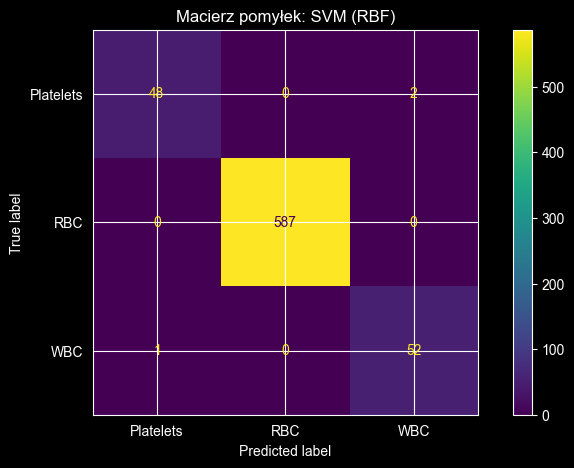


k-NN
              precision    recall  f1-score   support

   Platelets       0.98      0.96      0.97        50
         RBC       1.00      1.00      1.00       587
         WBC       0.96      0.96      0.96        53

    accuracy                           0.99       690
   macro avg       0.98      0.97      0.98       690
weighted avg       0.99      0.99      0.99       690



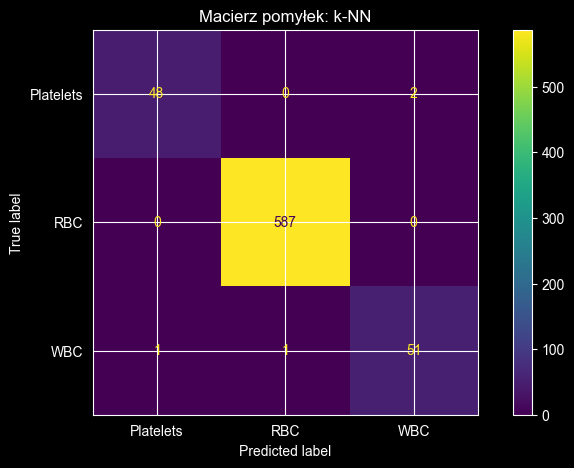


Random Forest
              precision    recall  f1-score   support

   Platelets       0.96      0.98      0.97        50
         RBC       0.99      1.00      1.00       587
         WBC       1.00      0.92      0.96        53

    accuracy                           0.99       690
   macro avg       0.99      0.97      0.98       690
weighted avg       0.99      0.99      0.99       690



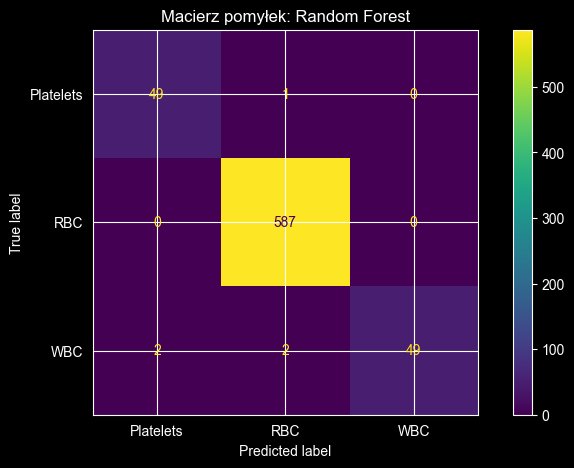

In [20]:
# Macierze pomyłek + raporty klasyfikacji
for name, model in models.items():
    y_pred = model.predict(X_test)

    print("\n" + "="*70)
    print(name)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
    disp.plot(values_format="d")
    plt.title(f"Macierz pomyłek: {name}")
    plt.show()

Macierze pomyłek wskazują, że najczęstsze błędy klasyfikacji występują pomiędzy klasami RBC i WBC. Klasa Platelets jest rozpoznawana z najwyższą dokładnością.


Błędy klasyfikacji wynikają głównie z podobieństwa morfologicznego krwinek czerwonych i białych, co stanowi naturalne ograniczenie analizowanego problemu.

Modele SVM oraz Random Forest osiągnęły bardzo zbliżone wyniki klasyfikacji, zarówno pod względem średniej accuracy, jak i rozkładu błędów w macierzach pomyłek.
Algorytm k-NN uzyskał wyraźnie gorsze rezultaty, szczególnie dla klas mniejszościowych.

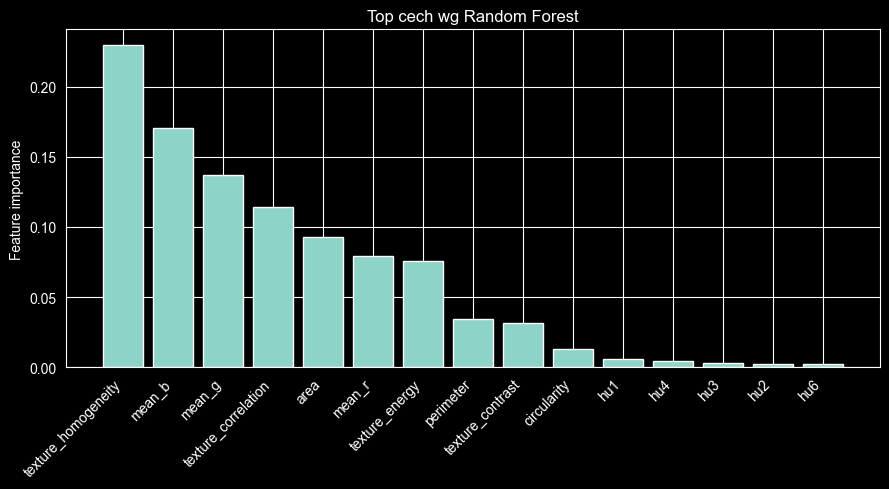

,feature,importance
0,texture_homogeneity,0.229373
1,mean_b,0.170748
2,mean_g,0.137012
3,texture_correlation,0.114357
4,area,0.092654
5,mean_r,0.079242
6,texture_energy,0.075527
7,perimeter,0.034571
8,texture_contrast,0.031842
9,circularity,0.013336


In [21]:
# Ważność cech dla Random Forest
rf = models["Random Forest"]
if hasattr(rf, "feature_importances_"):
    importances = rf.feature_importances_
    order = np.argsort(importances)[::-1]
    top_n = 15

    plt.figure(figsize=(9, 5))
    plt.bar(range(top_n), importances[order][:top_n])
    plt.xticks(range(top_n), [feature_cols[i] for i in order[:top_n]], rotation=45, ha="right")
    plt.title("Top cech wg Random Forest")
    plt.ylabel("Feature importance")
    plt.tight_layout()
    plt.show()

    display(pd.DataFrame({
        "feature": [feature_cols[i] for i in order],
        "importance": importances[order]
    }).head(20))


## Literatura

[1] R. Szeliski, Computer Vision: Algorithms and Applications, 2nd Edition, Springer, 2022.

[2] T. Hastie, R. Tibshirani, J. Friedman, The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Springer, 2013.